# Timestamps

RADICAL-Analytics (RA) enables event-based analyses in which the timestamps recorded in a RADICAL-Cybertools (RCT) session are studied as timeseries instead of durations. Those analyses are low-level and, most of the time, useful to 'visualize' the process of execution as it happens in one or more components of the stack.

<div class="alert alert-warning">
    
__Warning:__ Sessions with 100,000+ tasks and resoruces may generate traces with 1M+ events. Depending on the quantity of available memory, plotting that amount of timestamps with RA could not be feasable.

</div>

## Prologue

Load the Python modules needed to profile and plot a RCT session.

In [1]:
import tarfile

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import radical.utils as ru
import radical.pilot as rp
import radical.analytics as ra

from radical.pilot import states as rps

1664961066.909 : radical.analytics    : 29164 : 139866441418560 : INFO     : radical.analytics    version: 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build


Load the RADICAL Matplotlib style to obtain viasually consistent and publishable-qality plots.

In [2]:
plt.style.use(ra.get_mplstyle('radical_mpl'))

Usually, it is useful to record the stack used for the analysis. 

<div class="alert alert-info">
    
__Note:__ The analysis stack might be different from the stack used to create the session to analyze. Usually, the two stacks must have the same minor release number (Major.Minor.Patch) in order to be compatible.

</div>

In [3]:
! radical-stack

1664961067.411 : radical.analytics    : 29198 : 139673574983488 : INFO     : radical.analytics    version: 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build

  python               : /mnt/home/merzky/radical/radical.analytics.devel/ve3/bin/python3
  pythonpath           : 
  version              : 3.8.0
  virtualenv           : /mnt/home/merzky/radical/radical.analytics.devel/ve3

  radical.analytics    : 1.16.0-v1.16.0-24-g1ea17a5@fix-rtd_build
  radical.entk         : 1.16.0-v1.16.0@master
  radical.gtod         : 1.13.0
  radical.pilot        : 1.17.0-v1.17.0-148-g5a63a7f8e@devel
  radical.saga         : 1.17.0-v1.17.0-2-g5b9803bb@devel
  radical.utils        : 1.17.0-v1.17.0-4-ge3c8acb@fix-docs



## Event Model

RCT components have each a well-defined event model:

* [RADICAL-Pilot (RP) event model](https://github.com/radical-cybertools/radical.pilot/blob/devel/docs/source/events.md)
* [RADICAL-EnsembleToolkit (EnTK) event model](https://radicalentk.readthedocs.io/en/latest/dev_docs/uml.html#dev-docs-events)

<div class="alert alert-info">
    
__Note:__ RA does not support RADICAL-SAGA.

</div>

Each event belongs to an entity and is timestamped within a component. The succession of the same event over time constitutes a time series. For example, in RP the event `schedule_ok` belongs to a `task` and is timestamped by `AgentSchedulingComponent`. The timeseries of that event indicates the rate at which tasks are scheduled by RP.

## Timestamps analysis

We use RA to derive the timeseries for one or more events of interest. We then plot each time series singularly or together in the same plot. When plotting the time series of multiple events together, they must all be ordered in the same way. Typically, we sort the entities by the timestamp of their first event.

Here is the RA workflow for a timestamps analysis:

1. Go at [RADICAL-Pilot (RP) event model](https://github.com/radical-cybertools/radical.pilot/blob/devel/docs/source/events.md), [RP state model](https://github.com/radical-cybertools/radical.pilot/wiki/State-Model-Evolution) or [RADICAL-EnsembleToolkit (EnTK) event model](https://radicalentk.readthedocs.io/en/latest/dev_docs/uml.html#dev-docs-events) and derive the list of events of interest.
2. Convert events and states in RP/RA dict notation.

E.g., a scheduling event and state in RP:

* [schedule_ok: search for task resources succeeded (uid: task)](https://github.com/radical-cybertools/radical.pilot/blob/devel/docs/source/events.md#agentschedulingcomponent-component)
* [AGENT_SCHEDULING - picked up by agent scheduler, attempts to assign cores for execution](https://github.com/radical-cybertools/radical.pilot/wiki/State-Model-Evolution)

In [4]:
event = {ru.EVENT: 'schedule_ok'}
state = {ru.STATE: rps.AGENT_SCHEDULING}

3. Filter a RCT session for the entity to which the selected event/state belong.
4. use `ra.entity.timestamps()` and the defined event/state to derive the time series for that event/state.

### Session

Name and location of the session we profile.

In [5]:
sid = 'rp.session.rivendell.merzky.019270.0003'
sdir = 'sessions/'

Unbzip and untar the session.

In [6]:
sp = sdir + sid + '.tar.bz2'
tar = tarfile.open(sp, mode='r:bz2')
tar.extractall(path=sdir)
tar.close()

Create a ``ra.Session`` object for the session. We do not need EnTK-specific traces so load only the RP traces contained in the EnTK session. Thus, we pass the ``'radical.pilot'`` session type to ``ra.Session``.

<div class="alert alert-warning">
    
__Warning:__ We already know we need information about pilots and tasks. Thus, we save in memory two session objects filtered for pilots and tasks. This might be too expensive with large sessions, depending on the amount of memory available.

</div>
    
<div class="alert alert-info">
    
__Note:__ We save the ouput of ``ra.Session`` in ``capt`` to avoid polluting the notebook with warning messages. 

</div>

In [7]:
%%capture capt

sp = sdir + sid

session = ra.Session(sp, 'radical.pilot')
pilots  = session.filter(etype='pilot', inplace=False)
tasks   = session.filter(etype='task' , inplace=False)

We usually want to collect some information about the sessions we are going to analyze. That information is used for bookeeping while performing the analysis (especially when having multiple sessions) and to add meaningful titles to (sub)plots.

In [8]:
sinfo = {}

sinfo.update({
    'cores_node': session.get(etype='pilot')[0].cfg['resource_details']['rm_info']['cores_per_node'],
    'pid'       : pilots.list('uid'),
    'ntask'     : len(tasks.get())
})

sinfo.update({
    'ncores'    : session.get(uid=sinfo['pid'])[0].description['cores'],
    'ngpus'     : pilots.get(uid=sinfo['pid'])[0].description['gpus']
})

sinfo.update({
    'nnodes'    : int(sinfo['ncores']/sinfo['cores_node'])
})

Use `ra.session.get()` on the filtered session objects that contains only task entities. Then use `ra.entity.timestamps()` to derive the time series for each event/state of interest. We put the time series into a pandas DataFrame to make plotting easier. 

In [9]:
tseries = {'AGENT_SCHEDULING': [], 
           'schedule_ok': []}

for task in tasks.get():
    ts_state = task.timestamps(event=state)[0]
    ts_event = task.timestamps(event=event)[0]
    tseries['AGENT_SCHEDULING'].append(ts_state)
    tseries['schedule_ok'].append(ts_event)

time_series = pd.DataFrame.from_dict(tseries)
time_series.head()

,AGENT_SCHEDULING,schedule_ok
0,29.626037,29.679350
1,29.626037,29.680980
2,29.626037,29.682125
3,29.626037,29.683263
4,29.626037,29.684545


Usually, time series are plotted as lineplots but, in our case, we want to plot just the time stamps without a 'line' connecting those events, a potentially misleading artefact. Thus, we use a scatterplot in which the X axes are the number of tasks and the Y axes time in seconds. This somehow 'stretches' the meaning of a scatterplot as we do not use it to represent a correlation.

<div class="alert alert-info">
    
__Note:__ We need to zero the Y axes as the timestamps are taken starting from the first timestamp of the session. The event/state we choose are much later down the execution. Here we select the event/state that has to appen first, based on our knowledge of [RP's architecture](https://github.com/radical-cybertools/radical.pilot/wiki/Architecture). Alternatively, we could find the min among all the time stamps we have in the dataframe and use that as the zero point.

</div>

<div class="alert alert-info">

__Note:__ Once we have found the zero point in time (`zero`) we subtract it to the whole time series. Pandas' dataframe make that easy. We also add 1 to the index we use for the X axes so to start to count tasks from 1 instead of 0.

</div>

Text(0, 0.5, 'Time (s)')

findfont: Font family ['[DeJavu serif]'] not found. Falling back to DejaVu Sans.


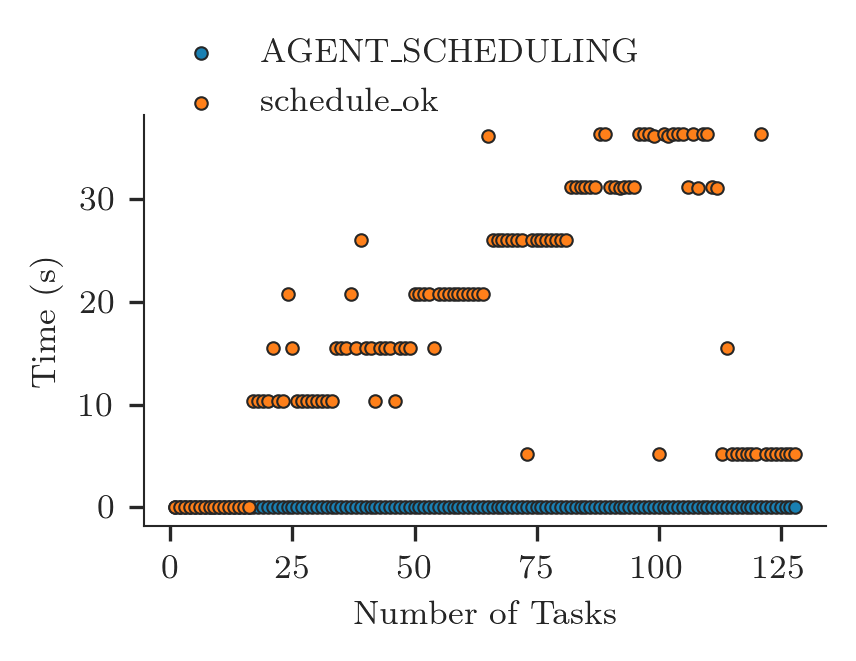

In [10]:
fig, ax = plt.subplots(figsize=(ra.get_plotsize(212)))

# Find the min timestamp of the first event/state timeseries and use it to zero
# the Y axes.
zero = time_series['AGENT_SCHEDULING'].min()

ax.scatter(time_series['AGENT_SCHEDULING'].index + 1, 
           time_series['AGENT_SCHEDULING'] - zero, 
           marker = '.', 
           label = ra.to_latex('AGENT_SCHEDULING'))
ax.scatter(time_series['schedule_ok'].index + 1, 
           time_series['schedule_ok'] - zero, 
           marker = '.', 
           label = ra.to_latex('schedule_ok'))

ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(0,1.25))
ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')

The plot above shows that all the tasks arrive at RP's Scheduler together (`AGENT_SCHEDULING` state). That is expected as tasks are transferred in bulk from RP Client's Task Manager to RP Agent's Staging In component.

The plot also shows that the 40 tasks are executed in two "generations". The first 20 tasks can be immediately scheduled (`schedule_ok`) and the second 20 tasks can be scheduled one by one, as soon as one of the first 20 tasks terminates to execute.

Adding execution events to our timestamps analysis should fill the gap between the two "generations" of 20 tasks. It should also confirm the [duration distributions](duration.ipynb#Distribution-of-Durations) of the time taken by RP's Executor launch method to launch tasks. 

We add the relevant events/states to the `time_series` dataframe.

In [11]:
executor = {
    'AGENT_EXECUTING': {ru.STATE: rps.AGENT_EXECUTING},
    'rank_start'     : {ru.EVENT: 'rank_start'},
    'rank_stop'      : {ru.EVENT: 'rank_stop'}
}

for name, event in executor.items():
    
    tseries = []    
    for task in tasks.get():
        ts_state = task.timestamps(event=event)[0]
        tseries.append(ts_state)
    
    time_series[name] = tseries
    
time_series.head()

,AGENT_SCHEDULING,schedule_ok,AGENT_EXECUTING,rank_start,rank_stop
0,29.626037,29.679350,29.685006,29.701557,34.705598
1,29.626037,29.680980,29.694608,29.705702,34.709754
2,29.626037,29.682125,29.698692,29.710951,34.715181
3,29.626037,29.683263,29.703309,29.715673,34.720114
4,29.626037,29.684545,29.708815,29.719791,34.723695


We plot the new time series alongside the previous ones.

Text(0, 0.5, 'Time (s)')

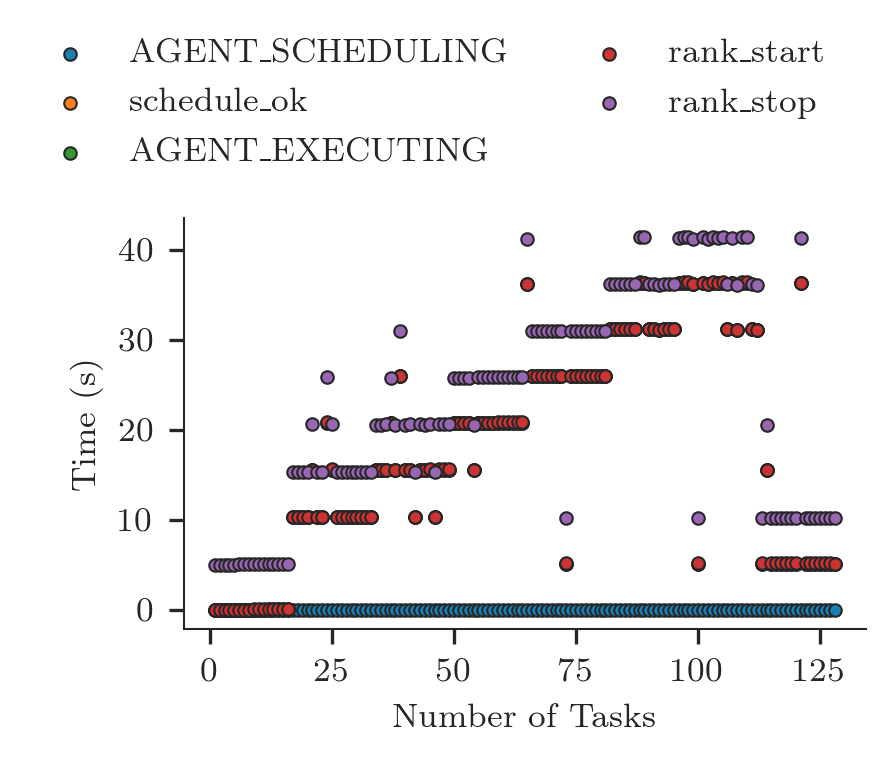

In [12]:
fig, ax = plt.subplots(figsize=(ra.get_plotsize(212)))

zero = time_series['AGENT_SCHEDULING'].min()

for ts in time_series.columns:    
    ax.scatter(time_series[ts].index + 1, 
               time_series[ts] - zero, 
               marker = '.', 
               label = ra.to_latex(ts))

ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.25,1.5))
ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')

`schedule_ok` is not visible in the plot because it is overlapped by `AGENT_EXECUTING` that happens right after each task has been scheduled. That confirms that the communication between the RP Scheduler and Executor components does not add significant overhead to the execution.

We see the time taken by the launch method (JSRUN on ORNL Summit in this case) to launch a task once it is handed out to RP's Executor: the distance between `AGENT_EXECUTING` and `rank_start` dots. The overall task execution time is consistent with that measured via the [duration analyses](duration.ipynb).

The plot also shows the time taken to execute each task: distance on the Y axes between light orange dots and dark green dots. Also in this case, that is consistent with what measured with the [duration analyses](duration.ipynb).

In presence of a large amount of tasks, we can slice the time stamps to plot one or more of their subsets. 

Text(0, 0.5, 'Time (s)')

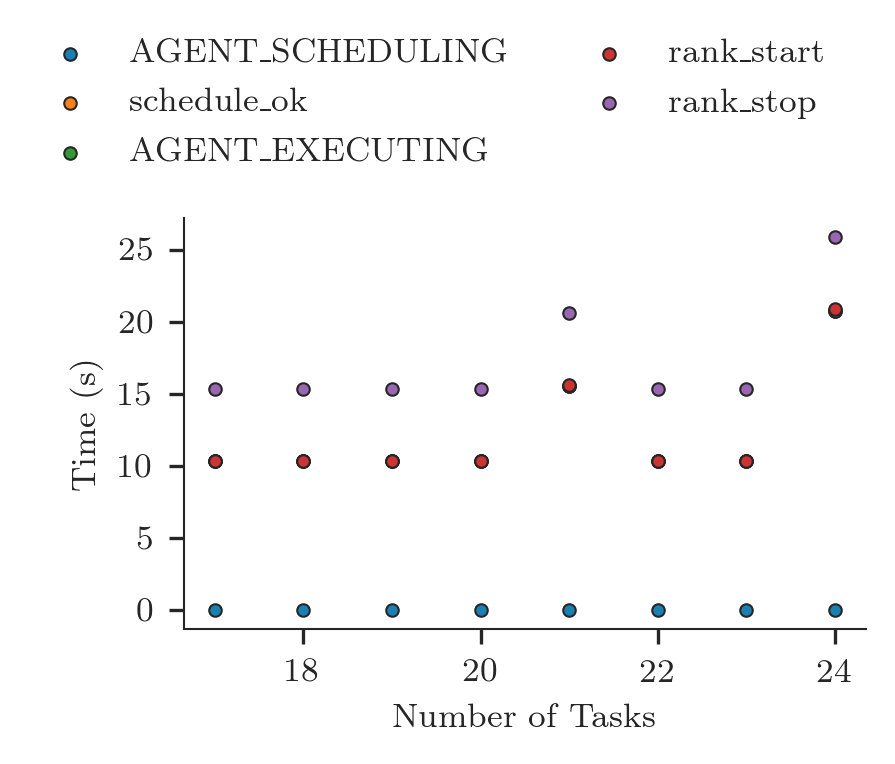

In [13]:
fig, ax = plt.subplots(figsize=(ra.get_plotsize(212)))

# Slice time series to plot only one of their subsets
time_series = time_series.reset_index(drop=True)
time_series = time_series.iloc[16:24]

zero = time_series['AGENT_SCHEDULING'].min()

for ts in time_series.columns:    
    ax.scatter(time_series[ts].index + 1, 
               time_series[ts] - zero, 
               marker = '.', 
               label = ra.to_latex(ts))

ax.legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.25,1.5))
ax.set_xlabel('Number of Tasks')
ax.set_ylabel('Time (s)')